In [4]:
from PIL import Image,ImageOps
import random
import os.path as osp
import os
import numpy as np
import math
import cv2
import glob
import multiprocessing
import re
import torch
import torch.nn as nn

import keras.callbacks as callbacks
import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
Image.MAX_IMAGE_PIXELS=None

%matplotlib inline

Using TensorFlow backend.


In [ ]:
class Datasets(Dataset ):

    def __init__(self, df, train="train", augment="weak",  transform=True):
        ids = df.id.values
        self.file_id = []
        url1 = "/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-pos-v1/*_mask.jpg"
        for fname in glob.glob(url):
            r = re.findall(r"(.*)_mask.jpg$",fname.split("/")[-1])
            file_id.join(r[0])




In [60]:
###Retina-Unet###
import pandas as pd

# 非mask  原图的名称
url2 = "/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-pos-v1/*[!_mask].jpg"
all_train_fn = glob.glob(url2)
n_pos = len(all_train_fn)
print(n_pos)
#url1 = "/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-pos-v1/*_mask.jpg"
url3 = "/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-neg/*.jpg"

all_neg_fn = glob.glob(url3)[:100]
all_train_fn.extend(all_neg_fn) 
mask_df = pd.DataFrame()
mask_df['file_names'] = all_train_fn
mask_df.set_index("file_names", inplace = True)
mask_df.reset_index(inplace=True)
print(mask_df.index)

mask_df['labels']=0
mask_df.loc[mask_df.index<n_pos,'labels'] = 1

mask_df

250
RangeIndex(start=0, stop=350, step=1)


,file_names,labels
0,/Users/eggwardhan/Documents/cv/DigestPath2019/...,1
1,/Users/eggwardhan/Documents/cv/DigestPath2019/...,1
2,/Users/eggwardhan/Documents/cv/DigestPath2019/...,1
3,/Users/eggwardhan/Documents/cv/DigestPath2019/...,1
4,/Users/eggwardhan/Documents/cv/DigestPath2019/...,1
...,...,...
345,/Users/eggwardhan/Documents/cv/DigestPath2019/...,0
346,/Users/eggwardhan/Documents/cv/DigestPath2019/...,0
347,/Users/eggwardhan/Documents/cv/DigestPath2019/...,0
348,/Users/eggwardhan/Documents/cv/DigestPath2019/...,0


In [64]:


from sklearn.model_selection import train_test_split,StratifiedKFold
#  split test and train dataset
total_samples = len(all_train_fn)
idx = np.arange(total_samples)
train_fn, val_fn = train_test_split(all_train_fn, stratify = mask_df.labels, test_size = 0.1, random_state=10)
print("No. of train files:", len(train_fn))
print("No. of val files:", len(val_fn))
train_fn[0:10]


No. of train files: 315
No. of val files: 35


['/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-pos-v1/D20180177401_2019-05-14 16_20_21-lv1-32193-32343-3516-6088.jpg',
 '/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-neg/2019-06-10 23_33_19-lv1-20982-23329-2501-3878.jpg',
 '/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-pos-v1/18-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803.jpg',
 '/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-neg/2019-06-11 09_15_18-lv1-23037-23173-3077-4387.jpg',
 '/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-neg/2019-06-04 17_17_30-lv1-21164-4782-5494-4074.jpg',
 '/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-pos-v1/18-04026B_2019-05-07 23_23_28-lv1-15774-15050-5461-4445.jpg',
 '/Users/eggwardhan/Documents/cv/DigestPath2019

In [69]:
import shutil

!mkdir ../DigestPath2019/train_mask
    
train_mask_dir = "../DigestPath2019/train_mask" #create  train mask
for full_fn in train_fn:
    fn = full_fn.split("/")[-1].split(".")[0]+"_mask.jpg" #无前缀纯mask文件名
    source_path = full_fn.split(".")[0]+"_mask.jpg" # 源mask名
    try:
        shutil.move(source_path, os.path.join(train_mask_dir, fn))
    except:
        size = Image.open(full_fn).size
        np_img=np.zeros(size,dtype=np.uint8)
        mask_img = Image.fromarray(np_img)
        mask_img.save(os.path.join(train_mask_dir, fn))

!mkdir ../DigestPath2019/train

train_dir = "../DigestPath2019/train" # create train data
for full_fn in train_fn:
    fn = full_fn.split("/")[-1]
    shutil.move(full_fn, os.path.join(train_dir, fn))


!mkdir ../DigestPath2019/val_mask

val_mask_dir = "../DigestPath2019/val_mask"
for full_fn in val_fn:
    fn = full_fn.split("/")[-1].split(".")[0]+"_mask.jpg"
    source_path = full_fn.split(".")[0]+"_mask.jpg" # 源mask名
    try:
        shutil.move(source_path, os.path.join(val_mask_dir, fn))
    except:
        size = Image.open(full_fn).size
        np_img=np.zeros(size,dtype=np.uint8)
        mask_img = Image.fromarray(np_img)
        mask_img.save(os.path.join(val_mask_dir, fn))  
        
!mkdir ../DigestPath2019/val
val_dir = "../DigestPath2019/val"
for full_fn in val_fn:
    fn = full_fn.split("/")[-1]
    shutil.move(full_fn, os.path.join(val_dir, fn))

    

In [61]:
#test create img
im ="/Users/eggwardhan/Documents/cv/DigestPath2019/Colonoscopy_tissue_segment_dataset/tissue-train-neg/2019-06-11 00_27_53-lv1-16800-16976-3004-3354.jpg"
size = Image.open(im).size
np_img=np.zeros(size,dtype=np.uint8)
mask_img = Image.fromarray(np_img)
mask_img.save(im+"_mask.jpg")



In [92]:
h,w,batch_size = 256,256,16

class DataGenerator(keras.utils.Sequence):
    def __init__(self, train_im_path=train_dir, train_mask_path=train_mask_dir,
                 augmentations=None, batch_size=batch_size,img_size=256,
                n_channels=3, shuffle=True):
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+"/*")
        self.train_im_path = train_im_path
        self.train_mask_path =  train_mask_path
        self.img_size = img_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.cell(len(self.train_im_paths)/self.batch_size))
    
    def __getitem__(self, index):
        # Generate indexes of  the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size, len(self.train_im_paths))]
        
        #Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]
        
        # Generate data
        X, y = self.data_generation(list_IDs_im)
        
        if self.augment is None:
            return X, np.array(y)/255
        else:
            im, mask = [],[]
            for x, y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255
    
    def on_epoch_end(self):
        # updates indexes after each epoch"
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def data_generation(self, list_IDs_im):
        # generates data containing batch_size samples
         # init array 
        X = np.empty((len(list_IDs_im),self.img_size, self.img_size,
                     self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size, self.img_size, 1))
        
        #generata data
        for i, im_path in enumerate(list_IDs_im):
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            mask_path = mask_path.rsplit(".",1)[0]+"_mask.jpg"
            mask = np.array(Image.open(mask_path))
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)
                
                # Resize sample
            X[i,] = cv2. resize(im,(self.img_size, self.img_size))
                # store class
            y[i,] = cv2.resize(mask,(self.img_size, self.img_size))[...,np.newaxis]
            y[y>0] = 255
        return np.uint8(X), np.uint8(y)

In [107]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(176, 256), height=h, width=w,p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

# train with mask

        

Text(0.5, 0.98, 'Colonoscopy_tissue_segment_dataset')

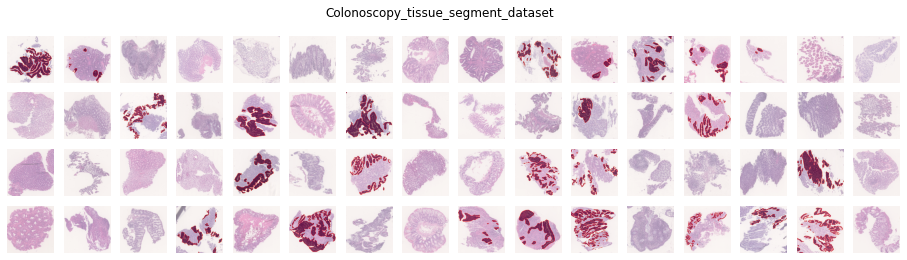

In [96]:
a = DataGenerator(batch_size = 64, shuffle = False)
images, masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im,mask) in enumerate(zip(images, masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap = "Reds")
    ax.axis("off")
plt.suptitle("Colonoscopy_tissue_segment_dataset")






Text(0.5, 0.98, 'Colonoscopy_tissue_segment_dataset')

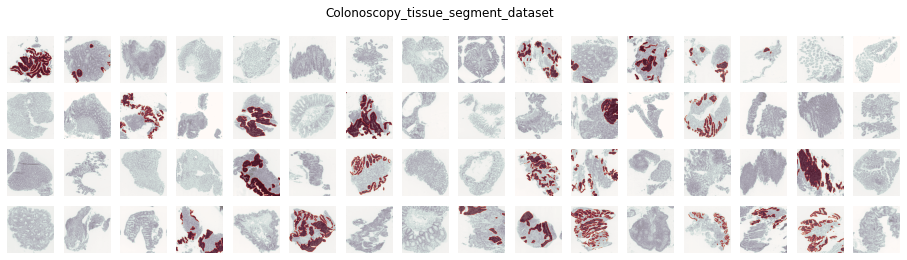

In [109]:
a = DataGenerator(batch_size=64,augmentations=AUGMENTATIONS_TRAIN,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im,mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap = "Reds")
    ax.axis("off")
plt.suptitle("Colonoscopy_tissue_segment_dataset")



## calculating IOU & dice loss


In [111]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
from keras import backend as K
from keras.losses import binary_crossentropy

def get_iou_vector(A, B):
    # Numpy version
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        #deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case. Union is never empty
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        metric += iou
    
    # take the average over all image in batch
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label,pred>0.5], tf.float64)
        

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))
        

In [ ]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
    
    def get_callbacks(self, model_prefix="Model"):
        callback_list=[
            callbacks.ModelCheckpoint("./keras.model",monitor="val_my_iou_metric",
                                     mode="max", save_best_only = True,
                                     verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]
        return callback_list
    
    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t %(self.T // self.M)) # t-1 is used when t has 1_based indexing
        cos_inner /=self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 *cos_out)
    
    
    
    
    
    
    

## defining model
### resnet34 +unet


In [115]:
import segmentation_models_pytorch as smp
# fast load model
model = smp.Unet("resnet34",encoder_weights="imagenet",activation=None)
model


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### resnet+unet pytorch version
 #### unet

In [143]:
def double_conv(in_channels, out_channels): #双层卷积模型，神经网络最基本框架
    return nn.Sequential(
        nn.Con2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),  #加入Bn层提高网络泛化能力（防止过拟合），加收敛速度
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1), #3指kernel_size，即卷积核3*3
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor = 2,
                                   mode="bilinear",
                                   align_corners = True)
        self.dconv_up3 = double_conv(256+512, 256)
        self.dconv_up2 = double_conv(128+256, 128)
        self.dconv_up1 = double_conv(128+62, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        #encode
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)    
        
        x = self.dconv_down4(x)
        
        #decode
        x = self.upsample(x)
        # pass the crop because 3*3 conv and padding=1, so the size keep the same
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out
        

#### ResNet

In [146]:
class BasicBlock(nn.Module):
#Basic Block for resnet 18 and resnet 34

    #BasicBlock and BottleNeck block 
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride = stride, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion,
                     kernel_size = 3, padding=1, bias = False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            
        )
        
        # shortcut
        self.shortcut = nn.Sequential()
        # the shortcut output dimension is not the same with residual function
        # use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BasicBLock.expansion,
                         kernel_size = 1, stride=stride,bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
    
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x)+self.shortcut(x))
    
    
class BottleNeck(nn.Module):
    #Residual block for resnet over 50 layers
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride = stride, kernel_size=3,
                     padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels*BottleNeck.expansion,
                     kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels*BottleNeck.expansion)
        )
        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
        
        def forward(self, x):
            return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes =100):
        super().__init__()

        self.in_channels = 64   #输入通道
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 7, stride = 2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # we use a different inputsize than the original paper
        # so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0],1)
        self.conv3_x = self._make_layer(block, 128, num_block[1],2)
        self.conv4_x = self._make_layer(block, 256, num_block[2],2)
        self.conv5_x = self._make_layer(block, 512, num_block[3],2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        '''
              make resnet layers(by layer i didnt mean this 'layer' was the 
        same as a neuron netowork layer, ex. conv layer), one layer may 
        contain more than one residual block 
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer 
        '''


    # we have num_block blocks per layer, the first block 
    # could be 1 or 2, other blocks would always be 1
        strides = [stride]+[1] * (num_blocks -1)
        layers=[]
        for stride in strides :
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.conv1(x)
        temp = self.maxpool(output)
        output = self.conv2_x(temp)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output
    

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34(in_channel, out_channel, pretrain=True):
    """ return a ResNet 34 object
    """
    model = ResNet(in_channel, out_channel, BasicBlock,[3,4,6,3])
    if pretrain:
        model.load_pretrained_weights()
    return model

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])                
        
        

#### resnet+Unet

In [2]:
import torch
import torch.nn as nn
from torchvision import models
train_mask_dir = "../DigestPath2019/train_mask" #create  train mask
train_dir = "../DigestPath2019/train"
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        #nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        #nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    # BasicBlock and BottleNeck block
    # have different output size
    # we use class attribute expansion
    # to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        # shortcut
        self.shortcut = nn.Sequential()

        # the shortcut output dimension is not the same with residual function
        # use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))



class ResNet(nn.Module):

    def __init__(self,in_channel,out_channel, block, num_block):
        super().__init__()
        #self.in_channels = in_channel
        self.outc = out_channel #不能加self.out_channel  不是很懂为啥 估计是变量优先级问题
        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size = 7, stride = 2, padding = 3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # we use a different inputsize than the original paper
        # so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        # self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.dconv_last=nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64,out_channel,1)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)# [stride, 1,1,1...]
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        print(x.shape)
        conv1 = self.conv1(x)
        temp=self.maxpool(conv1)
        print(temp.shape)
        print(self.conv2_x)
        conv2 = self.conv2_x(temp)
        conv3 = self.conv3_x(conv2)
        conv4 = self.conv4_x(conv3)
        bottle = self.conv5_x(conv4)
        # output = self.avg_pool(output)
        # output = output.view(output.size(0), -1)
        # output = self.fc(output)
        x = self.upsample(bottle)
        # print(x.shape)
        # print(conv4.shape)
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        # print(x.shape)
        # print(conv3.shape)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        # print(x.shape)
        # print(conv2.shape)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up1(x)
        x=self.upsample(x)
        # print(x.shape)
        # print(conv1.shape)
        x=torch.cat([x,conv1],dim=1)
        out=self.dconv_last(x)

        return out

    def load_pretrained_weights(self):
         # 导入自己模型的参数
        model_dict=self.state_dict()
        
        resnet34_weights = models.resnet34(True).state_dict()
        count_res = 0
        count_my = 0

        reskeys = list(resnet34_weights.keys())
        mykeys = list(model_dict.keys())
        # print(self)  自己网络的结构
        # print(models.resnet34())   resnet结构
        # print(reskeys)
        # print(mykeys)

        corresp_map = []
        while (True):              # 后缀相同的放入list
            reskey = reskeys[count_res]
            mykey = mykeys[count_my]

            if "fc" in reskey:
                break

            while reskey.split(".")[-1] not in mykey:
                count_my += 1
                mykey = mykeys[count_my]

            corresp_map.append([reskey, mykey])
            count_res += 1
            count_my += 1

        for k_res, k_my in corresp_map:
            model_dict[k_my]=resnet34_weights[k_res]

        try:
            self.load_state_dict(model_dict)
            print("Loaded resnet34 weights in mynet !")
        except:
            print("Error resnet 34 weights in mynet !")
            raise


def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])


def resnet34(in_channel,out_channel,pretrain=True):
    """ return a ResNet 34 object
    """
    model=ResNet(in_channel,out_channel,BasicBlock, [3, 4, 6, 3])
    if pretrain:
        model.load_pretrained_weights()
    return model


def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])


def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])


def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

if __name__ == '__main__':
    net = resnet34(3, 4, False) # out_channel = 4  4分类问题
    #print(net)
    x = torch.rand((1, 3, 512, 512)) #N，C, H, W
    print(net.forward(x).shape)


torch.Size([1, 3, 512, 512])
torch.Size([1, 64, 128, 128])
Sequential(
  (0): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (residual_function): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

## train


In [ ]:
# version 1 mile
# refer : https://github.com/milesial/Pytorch-UNet/blob/master/train.py
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
'''

from eval import eval_net
from unet import UNet
from utils.dataset import BasicDataset
'''

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, Dataset

'''dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'

'''

class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix='_mask'):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.mask_suffix = mask_suffix    
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [os.path.splitext(file)[0] for file in os.listdir(imgs_dir)
                    if not file.startswith('.')]   # get prefix or so-called id
        logging.info(f'Creating dataset with {len(self.ids)} examples')
        #print("image_directory:{}  with {} files.\nmask_dir:{}".format(imgs_dir,len(self.ids),masks_dir))
        
    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW   
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans
       
    def __getitem__(self, i):
        idx = self.ids[i]
        temp = os.path.join(self.masks_dir,idx+self.mask_suffix+'.*')
        # print(type(temp))
        #print("i:"+temp+"\n")
        mask_file = glob.glob(temp)
        
        img_file = glob.glob(os.path.join(self.imgs_dir , idx + '.*'))
        
        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)

        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }

def train_net(net,
              device,
              epochs=10,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5):

    dataset = BasicDataset(train_dir, train_mask_dir, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
    
    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0
    # 基本信息
    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')
    #优化器
    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.outc > 1 else 'max', patience=2)
    if net.outc > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.outc == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (n_train // (10 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)

        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('-e', '--epochs', metavar='E', type=int, default=5,
                        help='Number of epochs', dest='epochs')
    parser.add_argument('-b', '--batch-size', metavar='B', type=int, nargs='?', default=1,
                        help='Batch size', dest='batchsize')
    parser.add_argument('-l', '--learning-rate', metavar='LR', type=float, nargs='?', default=0.0001,
                        help='Learning rate', dest='lr')
    parser.add_argument('-f', '--load', dest='load', type=str, default=False,
                        help='Load model from a .pth file')
    parser.add_argument('-s', '--scale', dest='scale', type=float, default=0.5,
                        help='Downscaling factor of the images')
    parser.add_argument('-v', '--validation', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')


    return parser.parse_args()


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    args = get_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    #   - For 1 class and background, use n_classes=1
    #   - For 2 classes, use n_classes=1
    #   - For N > 2 classes, use n_classes=N
    #net = UNet(n_channels=3, n_classes=1, bilinear=True)
    net = resnet34(in_channel=3, out_channel=1)

    logging.info(f'Network:\n'
                 f'\t{net.in_channels} input channels\n'
                 f'\t{net.outc} output channels (classes)\n'
                 f'\t{"Bilinear" if args.load else "Transposed conv"} upscaling')
    
    '''？？？
        if args.load:
            net.load_state_dict(
                torch.load(args.load, map_location=device)
            )
            logging.info(f'Model loaded from {args.load}')

    '''

    net.to(device=device)
    # faster convolutions, but more memory
    # cudnn.benchmark = True

    try:
        train_net(net=net,
                  epochs=args.epochs,
                  batch_size=args.batchsize,
                  lr=args.lr,
                  device=device,
                  img_scale=args.scale,
                  val_percent=args.val / 100)
    except KeyboardInterrupt:
        torch.save(net.state_dict(), 'INTERRUPTED.pth')
        logging.info('Saved interrupt')
        try:
            sys.exit(0)
        except SystemExit:
            os._exit(0)


INFO: Using device cpu
INFO: Network:
	512 input channels
	1 output channels (classes)
	Bilinear upscaling
INFO: Creating dataset with 315 examples
INFO: Starting training:
        Epochs:          5
        Batch size:      1
        Learning rate:   0.0001
        Training size:   284
        Validation size: 31
        Checkpoints:     True
        Device:          cpu
        Images scaling:  0.5
    
Epoch 1/5:   0%|          | 0/284 [00:00<?, ?img/s]

Loaded resnet34 weights in mynet !
image_directory:../DigestPath2019/train  with 315 files.
mask_dir:../DigestPath2019/train_mask
<class 'str'><class 'str'><class 'str'><class 'str'><class 'str'><class 'str'><class 'str'>





<class 'str'>

1111111






1
<class 'str'><class 'str'><class 'str'>


<class 'str'>1
11


1


Epoch 1/5:   0%|          | 0/284 [04:37<?, ?img/s]


In [ ]:
# version 2

import os
import sys
import argparse
import time
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter



def train(epoch):
    strat = time.time()
    net.train()
    for batch_index, (images, labels) in enumerate(xxx):
        if args.gpu:
            labels = labels.cuda()
            images = images.cuda()
        optimizer.zero_grad()
        output = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        n_iter = (epoch -1)*len(xxx) + batch_index + 1
        
        last_layer = list(net.children())[-1]
        for name, para in last_layer.named_parameters():
            if 'weight' in name:
                writer.add_scalar("LastLayerGradients/grad_norm2_weights",
                                 para.grad.norm(), n_iter)
            if 'bias' in name:
                writer.add_scalar('LastLayerGradients/grad_norm2_bias',
                                 para.grad.norm(), n_iter)
        print("Training Epoch:{epoch}[trained_samples}/total_samples}]\tLoss:{:0.4f}\tLR:{:0.6f}".format(
        loss.item(),
        optimizer.param_group[0]['lr'],
        epoch=epoch,
        trained_samples=batch_index * args.b+len(images),
        total_samples = len(xxx)
        ))
        
        #update training loss for each iteratin
        writer.add_sccalar("Train/loss", loss.item(), n_iter)
        
        if epoch <= args.warm:
            warmup.schedulaer.step()
    for name,param in net.named_parameters():
        layer, attr = os.path.splitext(name)
        attr=attr[1:]
        writer.add_histogram("{}/{}".format(layer, attr), param, epoch)
    finish = time.time()

    print('epoch {} training time consumed: {:.2f}s'.format(epoch, finish - start))

In [157]:
from conf import settings
import argparse
import sys
from models.resnet import resnet34
        
if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('-net', type=str, default='resnet34', help='net type')

    parser.add_argument('-gpu', action='store_true', default=False, help='use gpu or not')
    parser.add_argument('-b', type=int, default=128, help='batch size for dataloader')
    parser.add_argument('-warm', type=int, default=1, help='warm up training phase')
    parser.add_argument('-lr', type=float, default=0.1, help='initial learning rate')
    parser.add_argument('-resume', action='store_true', default=False, help='resume training')
    args = parser.parse_args(args=[])
    if args.net == 'resnet34':
        net = resnet34()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
    train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[30,80,120],gamma=0.2)
    iter_per_epoch = len(xxx)
    warmup_sceduler = WarmUpLR(optimizer, iter_per_epoch * args.warm)
    
    if args.resume:
        recent_folder = most_recent_folder(os.path.join(settings.CHECKPOINT_PATH, args.net),fmt=settings.DATE_FORMAT)
        if not recent_folder:
            raise Exception("no recnet folder were found")
        checkpoint_path = os.path.join(settings.CHECKPOINT_PATH,  args.net, recent_folder)
    
    else:
        checkpoint_path = os.path.join(settings.CHECKPINT_PATH,  args.net, settings.TIME_NOW)
        
    #use tensorboard
    if not os.path.exists(settings.LOG_DIR):
        os.mkdir(settings.LOG_DIR)
    
    #since tensorboard can't overwirte old values
    # so the only way is to create a new tensorboard log
    writer = SummaryWriter(log_dir=os.path.join(
            settings.LOG_DIR,  args.net, settings.TIME_NOW))
    input_tensor = torch.Tensor(1, 3, 32, 32)
    if args.gpu:
        input_tensor = input_tensor.cuda()
    writer.add_graph(net, input_tensor)
    
    # create checkpoint folder to save model
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_path = os.path.join(checkpoint_path, '{net}-{epoch}-{type}.pth')
    
    best_acc = 0.0
    if args.resume:
        best_weights = best_acc_weights(os.path.join(settings.CHECKPOINT_PATH,args.net, recent_folder))
        if best_weights:
            weights_path = os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder, best_weight)
            print("found best acc weights file:{}".format(weights_path))
            print("load best training file to test acc")
            net.load_state_dict(torch.load(weights_path))
            best_acc = eval_training(tb=False)
            print("best acc is {:0.2f}".format(best_acc))
            
        recent_weights_file = most_recent_weights(os.path.join(settings.CHECKPOINT_PATH, net, recent_folder))
        if not recent_wieghts_file:
            raise Exception("no recent weights file were found")
        weights_path = os.path.join(settings.CHECKPOINT_PATH,args.net, recent_folder, recent_weights_file)
        print('loading weights file {} to resume training.....'.format(weights_path))
        net.load_state_dict(torch.load(weights_path))

        resume_epoch = last_epoch(os.path.join(settings.CHECKPOINT_PATH, args.net, recent_folder))
    
    
    for epoch in range(1, settings.EPOCH + 1):
        if epoch > args.warm:
            train_scheduler.step(epoch)
        
        if args.resume:
            if epoch <= resume_epoch:
                continue
        train(epoch)
        acc = eval_training(epoch)
        
        # start to save best performance model after learning ratedacay to 0.01
        if epoch > settings.MILESTONES[1] and best_acc<acc:
            weights_path = checkpoint_path.format(net=args.net, epoch = epoch,type="best")
            print('saving weights file to {}'.format(weights_path))
            torch.save(net.state_dict(), weights_path)
            best_acc = acc
            continue
        
        if not epoch % settings.SAVE_EPOCH:
            weights_path = checkpoint_path.format(net=args.net, epoch=epoch, type='regular')
            print('saving weights file to {}'.format(weights_path))
            torch.save(net.state_dict(), weights_path)
        
    writer.close()
        
        
        
        
        

ModuleNotFoundError: No module named 'models'

In [159]:
#version3
#https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch
class Trainer(object):
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 40
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_folder,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        

'../DigestPath2019/train'